In [1]:
import numpy as np
import copy 

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.ticker import LinearLocator

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms 
from torchvision import models
from torchvision import datasets
from torchvision.models.googlenet import GoogLeNet_Weights
import loss_landscapes


Load data 

In [2]:
# Transform the data so that it works with GoogLeNet (documentation on pythorch)
transform = transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

training_set = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True,)
validation_set = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True,)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)


Model 

In [3]:
# Load the (pre-trained) model
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT) 

# Replace the final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

# Set the model to training mode and use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler to adjust the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Fine-tuning the model

In [4]:
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()

     
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Fine-tuning complete!')

torch.save(model.state_dict(), 'finetuned_googlenet_fmnist.pth')
print('Model saved!')


Epoch [1/5], Loss: 0.3851
Epoch [2/5], Loss: 0.1467
Epoch [3/5], Loss: 0.3295
Epoch [4/5], Loss: 0.0207
Epoch [5/5], Loss: 0.5536
Fine-tuning complete!
Model saved!


Evaulating the model 

In [5]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0
loss = 0

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
        loss += criterion(outputs, labels).item() * labels.size(0)

print(f'Loss of the fine-tuned model on the test images: {loss / len(validation_loader.dataset):.4f}')
print(f'Accuracy of the fine-tuned model on the test images: {100 * correct / total:.2f}%')


Loss of the fine-tuned model on the test images: 0.1668
Accuracy of the fine-tuned model on the test images: 94.61%


Loss Landscape 

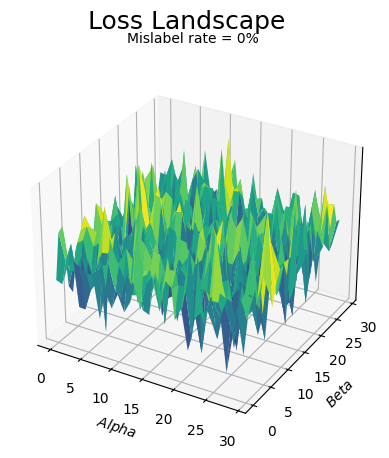

In [6]:
# Create datasets for training & validation
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
# improves data retrieval
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size= 4, shuffle=False)

learnt_model = 'models/finetuned_mislabeled90_googlenet_fmnist.pth'
learnt_net = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

in_features = learnt_net.fc.in_features
learnt_net.fc = nn.Linear(in_features, 10)
learnt_net.load_state_dict(torch.load(learnt_model, map_location=torch.device('cpu'), weights_only=True))

device = torch.device("cpu")
learnt_net = learnt_net.to(device)

STEPS = 30
distance = 2e6
loss_fn = nn.CrossEntropyLoss()

x, y = iter(validation_loader).__next__()
metric = loss_landscapes.metrics.Loss(loss_fn, x, y)

model_final = copy.deepcopy(learnt_net)

loss_data_fin = loss_landscapes.random_plane(model_final, metric, distance, STEPS, normalization='filter', deepcopy_model=True)

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# Customize the z axis.
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_zticks([])

plt.suptitle("Loss Landscape", y=1, fontsize=18)
plt.title("Mislabel rate = 0% \n ", fontsize=10)
ax.set_xlabel('$Alpha$', rotation=150)
ax.set_ylabel('$Beta$')
ax.set_zlabel('$Loss$', rotation=60)


plt.savefig("images/googlenet_loss.pdf", format='pdf')
